In [49]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    f1_score,
    recall_score,
    RocCurveDisplay
)

# settings
pd.set_option("display.max_columns", None)

In [50]:
df = pd.read_csv("../data/sanctions_features.csv")
df.head()

,cleaned_name,fuzz_ratio_reference,fuzz_ratio,token_sort_ratio,length_diff,common_token_count,prefix_match,word_count_1,word_count_2
0,AEROCARIBBEAN AIRLINES,REVIVAL OF SOCIETY,35.0,35.0,4,0,0,2,3
1,ANGLO CARIBBEAN CO LTD,REVIVAL OF SOCIETY,40.0,40.0,4,0,0,4,3
2,BANCO NACIONAL DE CUBA,REVIVAL OF SOCIETY,30.0,30.0,4,0,0,4,3
3,BANCO NACIONAL DE CUBA,REVIVAL OF SOCIETY,30.0,30.0,4,0,0,4,3
4,BANCO NACIONAL DE CUBA,REVIVAL OF SOCIETY,30.0,30.0,4,0,0,4,3


In [51]:
# Keep only rows with reference names
df = df[~df['fuzz_ratio_reference'].isna()].copy()

df['is_match'] = ((df['fuzz_ratio'] > 50) & (df['common_token_count'] > 0)).astype(int)

print(df['is_match'].value_counts())

is_match
0    45200
1     4139
Name: count, dtype: int64


In [52]:
# Prepare train/test split
X = df.drop(columns=["is_match", "cleaned_name", "fuzz_ratio_reference"])
y = df["is_match"]

print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

is_match
0    45200
1     4139
Name: count, dtype: int64


In [53]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [54]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [55]:
# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss",
    scale_pos_weight=(y == 0).sum() / ( y == 1).sum(),
    random_state=42
)
xgb.fit(X_train, y_train)

c:\xampp\htdocs\data-engineering\ofac-end-to-end-data-project\sanction-risk-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:09:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
# Evaluate Performance
def evaluate_model(model, name):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    print(f"Results for {name}")
    print(classification_report(y_test, preds, digits=3))
    print(f"AUC-ROC: {roc_auc_score(y_test, probs):.3f}")
    print("-" * 40)

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

In [57]:
import joblib
joblib.dump(xgb, "../models/xgb_sanction_model.pkl")

['../models/xgb_sanction_model.pkl']

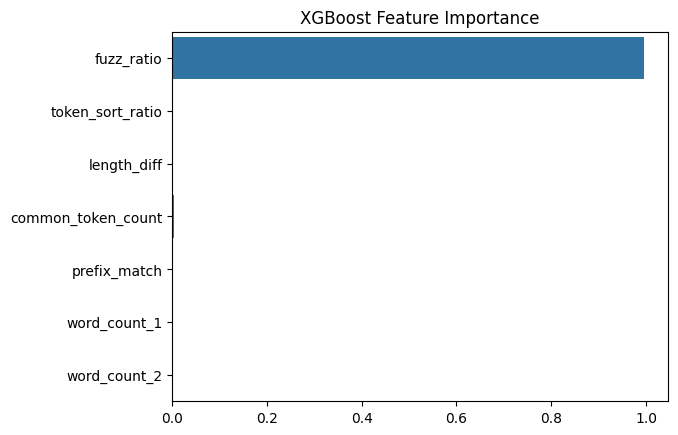

In [58]:
# Feature importance
feature_importances = xgb.feature_importances_
feat_names = xgb.feature_names_in_
sns.barplot(x=feature_importances, y=feat_names)
plt.title("XGBoost Feature Importance")
plt.show()

pd.DataFrame({
    "feature": feat_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False).to_csv("../data/feature_importances.csv", index=False)

In [59]:
final_output = X_test.copy()
final_output["actual"] = y_test
final_output["predictions"] = xgb.predict(X_test)
final_output["probability"] = xgb.predict_proba(X_test)[:, 1]
final_output.to_csv("../data/xgb_predictions.csv", index=False)

Results for Logistic Regression
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9040
           1      0.996     1.000     0.998       828

    accuracy                          1.000      9868
   macro avg      0.998     1.000     0.999      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


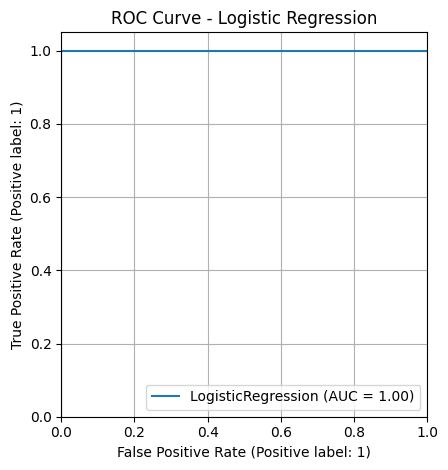

Results for Random Forest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9040
           1      1.000     1.000     1.000       828

    accuracy                          1.000      9868
   macro avg      1.000     1.000     1.000      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


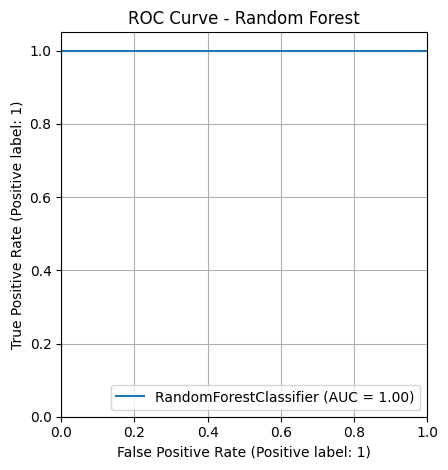

Results for XGBoost
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9040
           1      1.000     1.000     1.000       828

    accuracy                          1.000      9868
   macro avg      1.000     1.000     1.000      9868
weighted avg      1.000     1.000     1.000      9868

AUC-ROC: 1.000
----------------------------------------


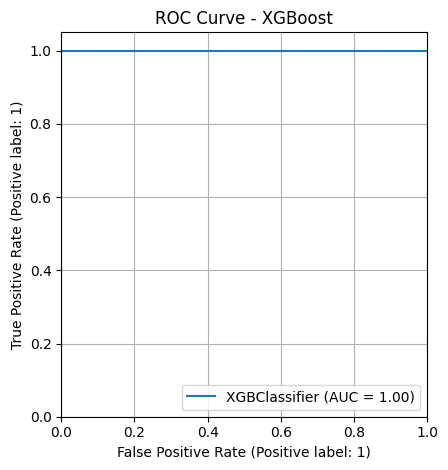

In [60]:
import csv
from datetime import datetime

version = "v1.0"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Path for the log files
model_config_log_file_path = "../data/model_config_log.csv"

def log_performance(model_name, y_true, y_pred, y_probs):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    
    with open("../data/performance_log.csv", mode="a", newline="") as f:
        writer = csv.writer(f)
        if not os.path.exists("../data/performance_log.csv"):
            writer.writerow(["model", "precision", "recall", "f1_score", "auc_roc", "timestamp", "version"])
        writer.writerow([model_name, precision, recall, f1, auc, timestamp, version])

    with open("../data/model_config_log.csv", mode="a", newline="") as f:
        writer = csv.writer(f)
        if not os.path.exists("../data/model_config_log.csv"):
            writer.writerow(["model", "params", "timestamp", "version"])
        writer.writerow([model_name, str(model.get_params()), timestamp, version])

# Evaluate and log
for name, model in [("Logistic Regression", lr), ("Random Forest", rf), ("XGBoost", xgb)]:
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    evaluate_model(model, name)
    log_performance(name, y_test, preds, probs)
